# Importing Packages

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from torch.autograd import Variable

# Reading and Transforming Data

In [2]:
cols=['category','message']
data= pd.read_csv("/content/SMSSpamCollection.tsv", delimiter='\t', names=cols)
data.head()

,category,message
0,ham,I've been searching for the right words to tha...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro..."
3,ham,Even my brother is not like to speak with me. ...
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!


Let's do some transformations!

In [3]:
data['category']=data['category'].map({'ham':0,'spam':1})
data.head()

,category,message
0,0,I've been searching for the right words to tha...
1,1,Free entry in 2 a wkly comp to win FA Cup fina...
2,0,"Nah I don't think he goes to usf, he lives aro..."
3,0,Even my brother is not like to speak with me. ...
4,0,I HAVE A DATE ON SUNDAY WITH WILL!!


In [4]:
# Making arrays for labels and features

features=data.message.values
labels=data.category.values
print(features.shape)
print(labels.shape)

(5568,)
(5568,)


In [5]:
t = Tokenizer(num_words=1000)
t.fit_on_texts(features)
features = t.texts_to_matrix(features, mode='tfidf')

In [6]:
features.shape

(5568, 1000)

# Building Model

In [7]:
class Model(nn.Module):
  def __init__(self,input,hidden,output):
    super(Model,self).__init__()
    self.l1=nn.Linear(input,hidden)
    self.l2=nn.Linear(hidden,hidden)
    self.l3=nn.Linear(hidden,output)

  def forward(self,x):
    x = self.l1(x)
    out= F.relu(x)
    out=F.relu(self.l2(out))
    out=self.l3(out)
    return out


In [8]:
INPUT=1000
HIDDEN=100
OUTPUT=2
model=Model(INPUT,HIDDEN,OUTPUT)

In [9]:
# Calculaitng Params 
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) #(1000*100+100)+(100*100+10)+(100*2+2)=110,402
print(pytorch_total_params)

110402


In [10]:
# Let's do train/test split
X_train,X_test, y_train,y_test=train_test_split(features,labels,shuffle=True)

In [11]:
# Let's define our loss function and optimization technique
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training and Testing Model
Using:
1. Using batch gradient descent
2. Corssentropy loss function
3. Adam optimizer

In [12]:
# let's use batch gradient descent for training our baby that we created above! (if epochs=10 then 10 exposures to entire training data for learning)
def train_test(epochs,lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr)
    x_train = Variable(torch.from_numpy(X_train)).float()
    y_train_ = Variable(torch.from_numpy(y_train)).long()
    x_test = Variable(torch.from_numpy(X_test)).float()
    y_test_ = Variable(torch.from_numpy(y_test)).long()
    train_losses=[]
    test_losses=[]
    model.train() # Each iteration of for loop updates our model's parameters through backpropagation
    for epoch in range(epochs):
        optimizer.zero_grad() 
        #let's forward pass and calculate train_loss
        y_pred_train = model(x_train)
        train_loss = loss(y_pred_train, y_train_)
        #let's forward pass and calculate test_loss
        y_pred_test = model(x_test)
        test_loss = loss(y_pred_test, y_test_)
        # Let's register train and test losses for each epoch by appending relevant lists
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        # Let's print train_loss and test_loss for each epoch
        # print ("epoch #",epoch+1)
        # print ("train_loss: ", train_loss.item())
        # print ("test_loss: ", test_loss.item())
        # Let's compute correct train and test predictions
        pred_train = torch.max(y_pred_train, 1)[1].eq(y_train_).sum()######smokeeeeeeeeeeeeeeeeeees!(Expanded below)
        pred_test = torch.max(y_pred_test, 1)[1].eq(y_test_).sum()
        # Let's print train and test accuracies
        # print ("train acc:(%) ", (100*pred_train/len(x_train)))
        # print ("test acc:(%) ", (100*pred_test/len(x_test)))
        train_loss.backward()
        #test_loss.backward()
        optimizer.step()
    return (y_pred_train, train_losses,test_losses,model)

### Experimentation
Let's expand `torch.max(y_pred, 1)[1].eq(y_train_).sum()` for comprehension

In [13]:
# a=train_test(1)[0]
# a # a is equivalent to y_pred from above

In [14]:
# torch.max(a) # collects max value of entire matrix

In [15]:
# torch.max(a,1) # collections max value row-wise

In [16]:
# torch.max(a,1)[1]

In [17]:
# y_train_ = Variable(torch.from_numpy(y_train)).long()
# torch.max(a,1)[1].eq(y_train_)


In [18]:
# torch.max(a,1)[1].eq(y_train_).sum() # total number of correct predictions on training set

# Plotting Train/Test Loss

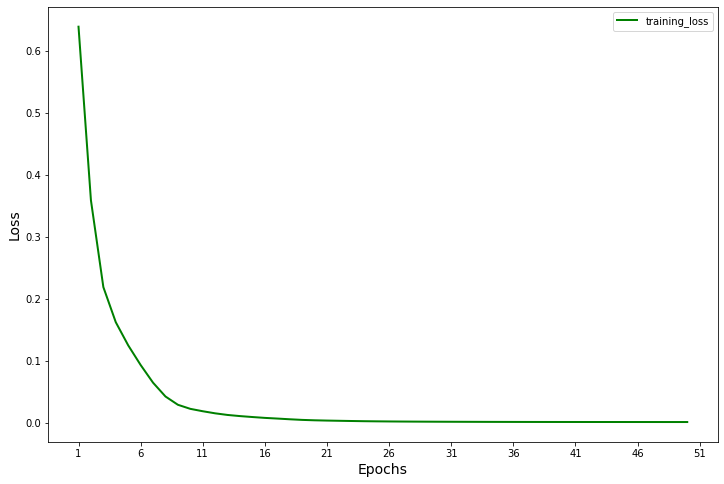

In [19]:
plt.figure(figsize=(12,8))
plt.plot([i for i in range(1,51,1)],train_test(50)[1],lw=2, color='green',label='training_loss')
plt.xlabel('Epochs',size=14)
plt.ylabel('Loss',size=14)
plt.xticks([i for i in range(1,52,5)],labels=[i for i in range(1,52,5)])
plt.legend()
plt.show()

In [20]:
# plt.figure(figsize=(12,8))
# plt.plot([i for i in range(1,51,1)],train_test(50)[2],lw=2, color='red',label='testing_loss')
# plt.xlabel('Epochs',size=14)
# plt.ylabel('Loss',size=14)
# plt.xticks([i for i in range(1,52,5)],labels=[i for i in range(1,52,5)])
# plt.legend()
# plt.show()

# Classification Report

In [21]:
from sklearn.metrics import confusion_matrix
model=train_test(11)[3] # epochs=11, getting 3rd element of tuple returned by train_test func
test_pred=model(torch.from_numpy(X_test).float())
test_pred= torch.max(test_pred,1)[1]
test_pred.data.numpy()
cm=confusion_matrix(y_test,test_pred)
print('test\n',cm)

train_pred=model(torch.from_numpy(X_train).float())
train_pred= torch.max(train_pred,1)[1]
train_pred.data.numpy()
cm=confusion_matrix(y_train,train_pred)
print('train:\n',cm)

test
 [[1201   12]
 [  13  166]]
train:
 [[3609    0]
 [   0  567]]
